Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[*********************100%***********************]  3 of 3 completed
Downloaded 250 rows of data.


Start date,2018-01-03
End date,2018-12-28
Total months,11
,Backtest
Annual return,-4.8%
Cumulative returns,-4.8%
Annual volatility,23.3%
Sharpe ratio,-0.10
Calmar ratio,-0.17
Stability,0.12
Max drawdown,-27.9%


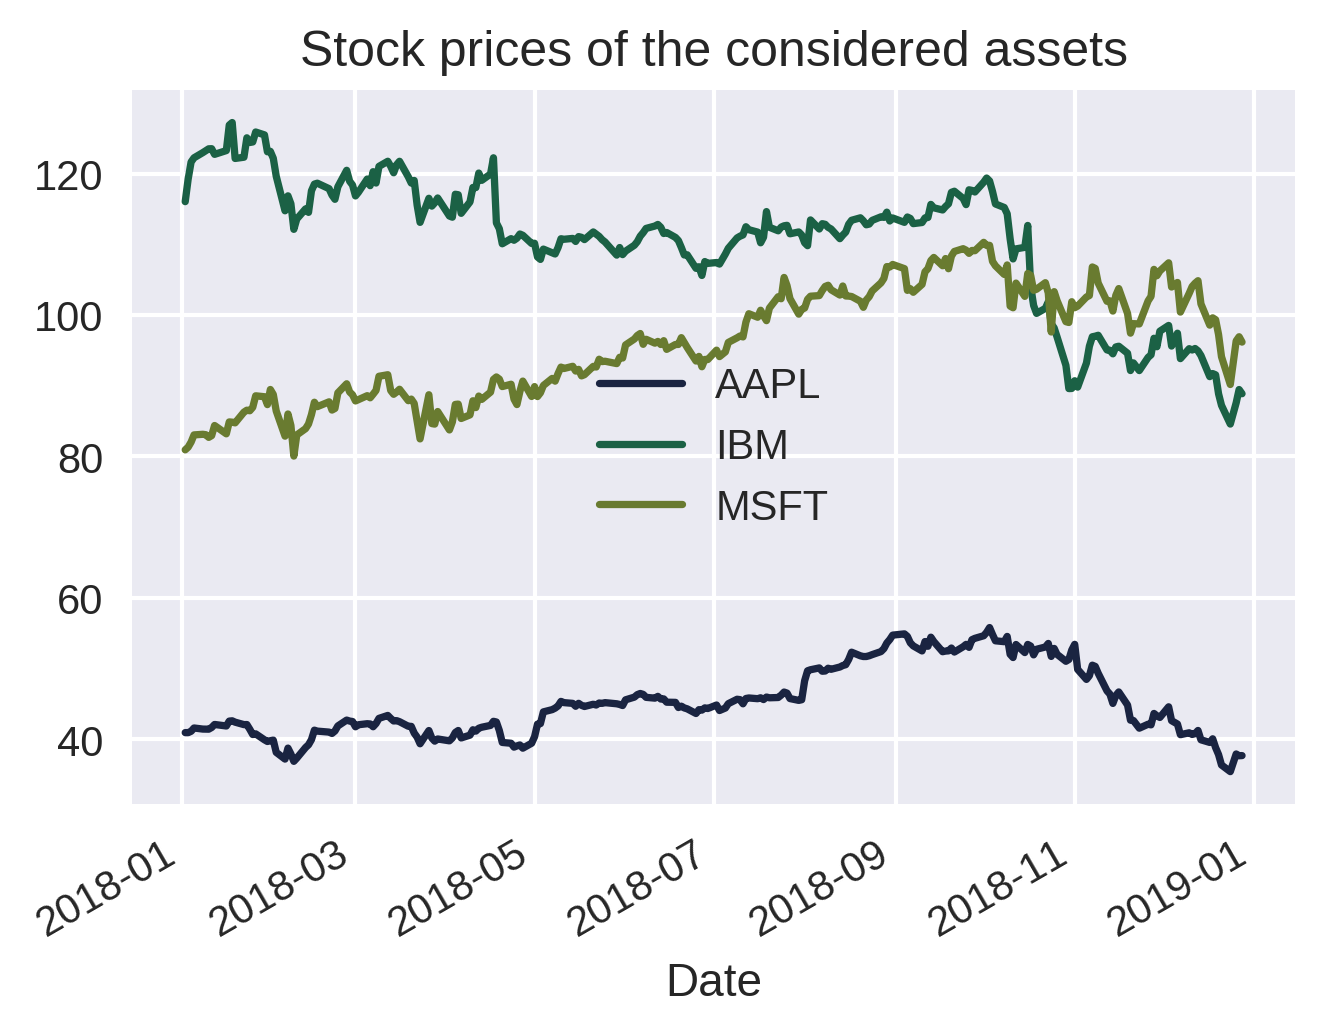

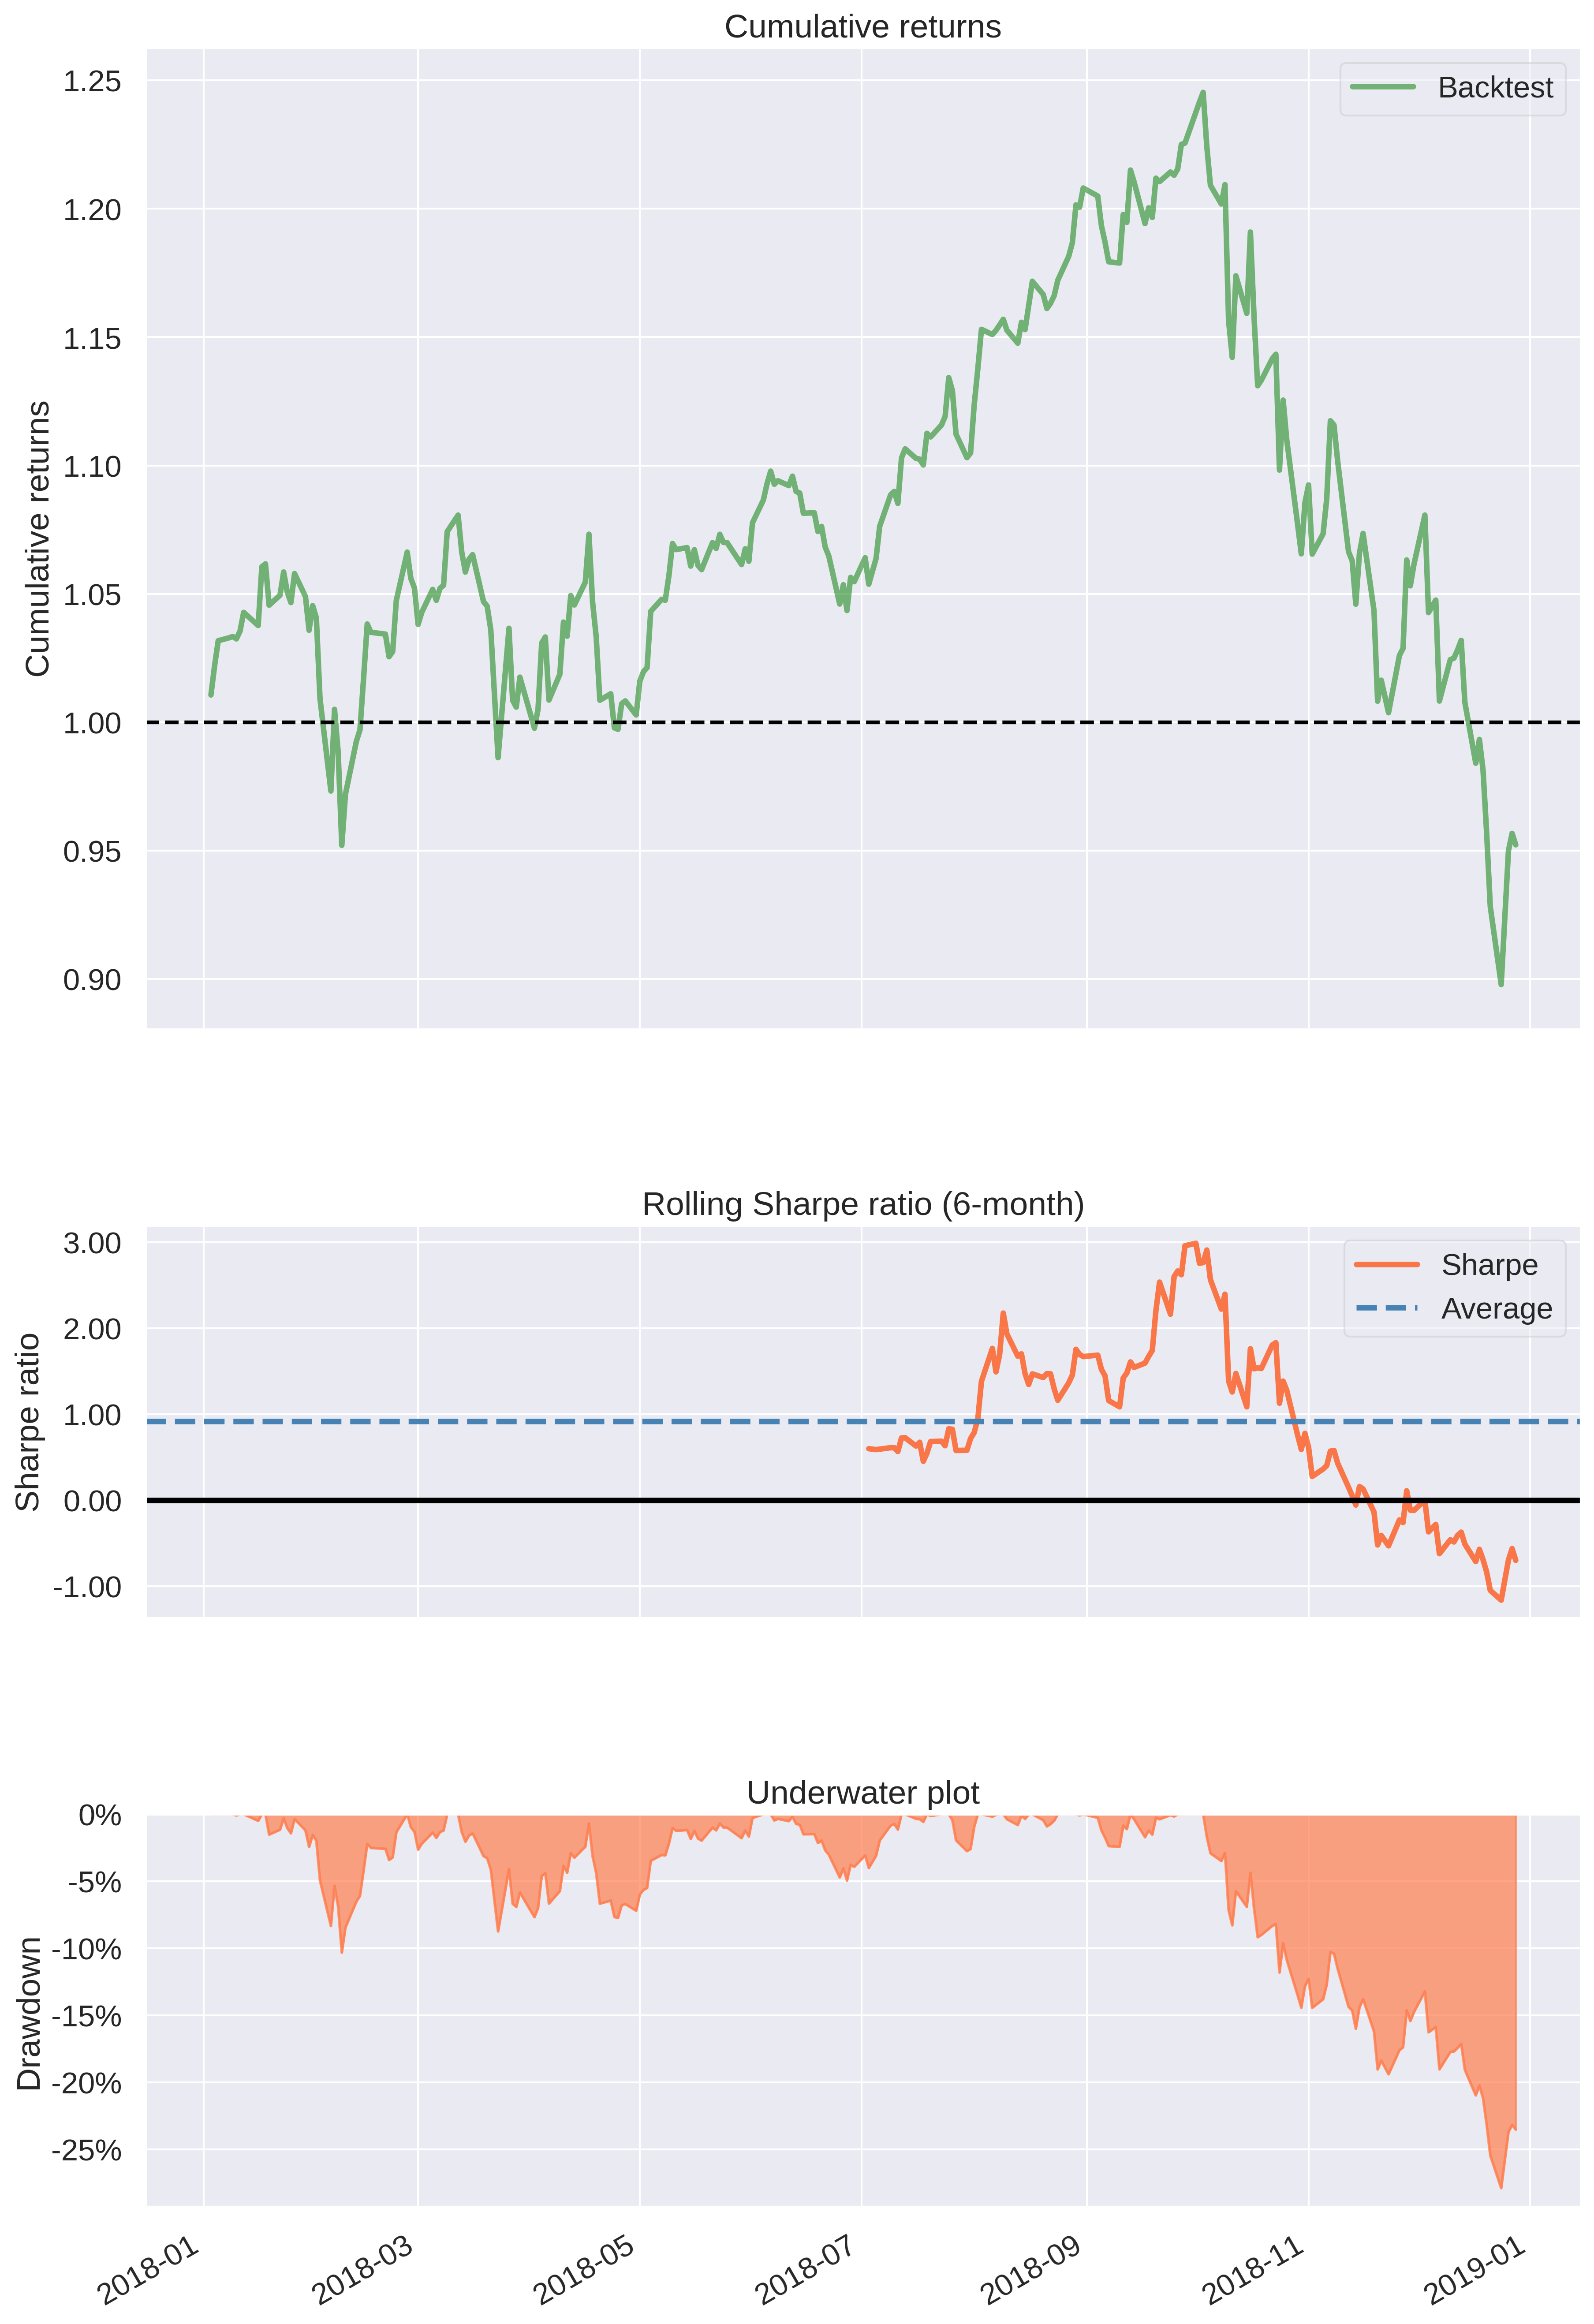

In [148]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

plt.style.use('seaborn')
sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams['figure.dpi'] = 150
warnings.simplefilter(action='ignore', category=FutureWarning)

!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
!pip install pyfolio
import pyfolio as pf

RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')
prices_df['Adj Close'].plot(title='Stock prices of the considered assets')

returns = prices_df['Adj Close'].pct_change().dropna()
portfolio_weights = n_assets * [1/n_assets]

portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T), 
                              index=returns.index)
pf.create_simple_tear_sheet(portfolio_returns)


In [149]:
import yfinance as yf
import numpy as np
import pandas as pd

2. Set up the parameters:

In [150]:
N_PORTFOLIOS = 10 ** 5 
N_DAYS = 252 
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
RISKY_ASSETS.sort()
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

3. Download the stock prices from Yahoo Finance:

In [151]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%***********************]  3 of 3 completed
Downloaded 250 rows of data.


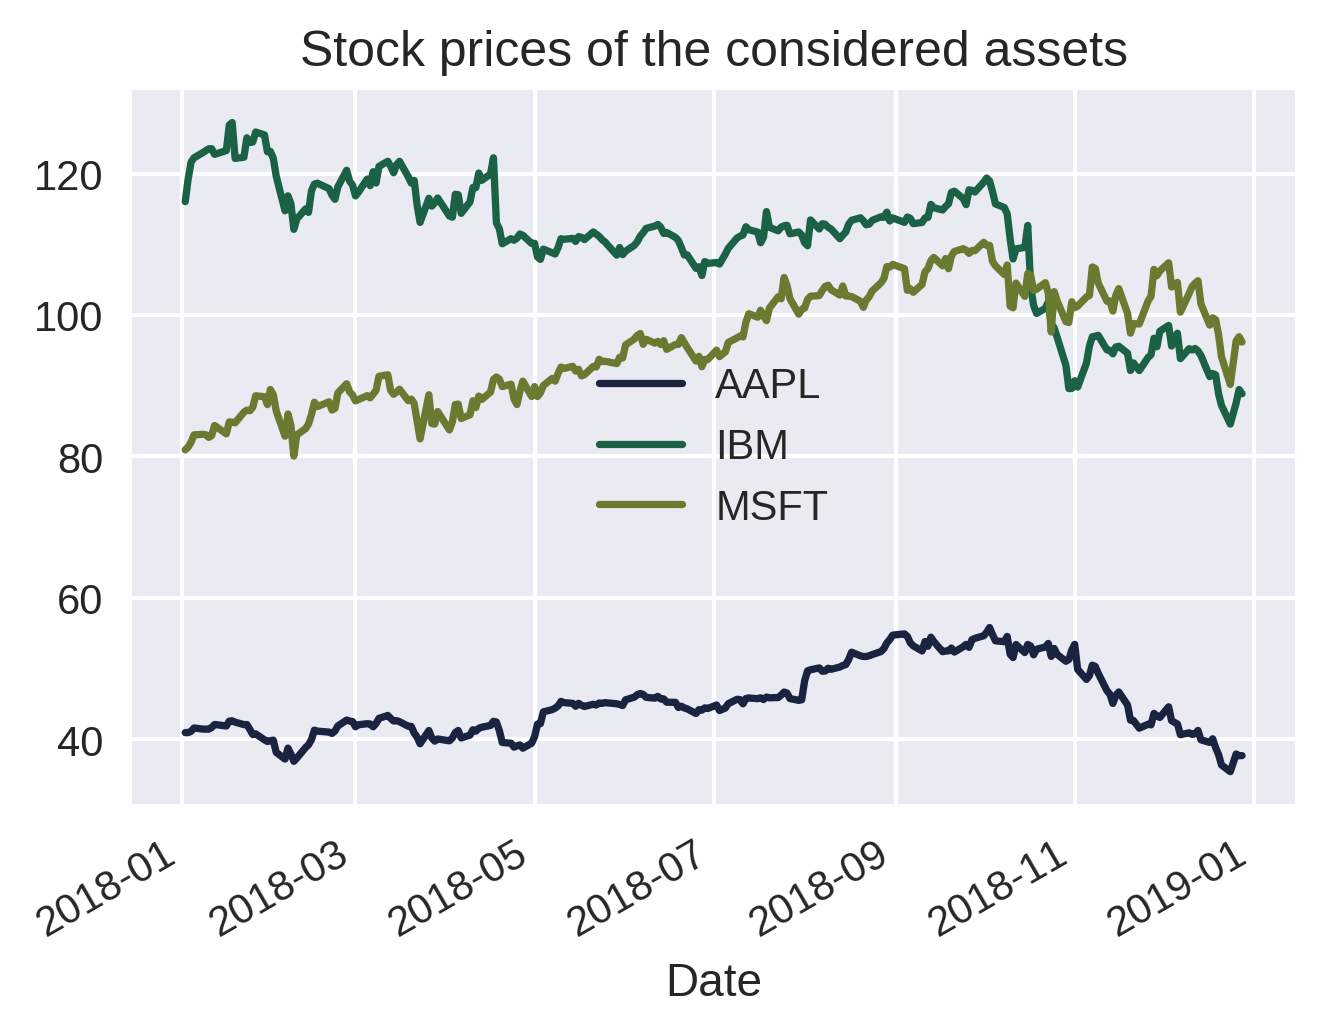

In [152]:
prices_df['Adj Close'].plot(title='Stock prices of the considered assets')

4. Calculate annualized average returns and the corresponding standard deviation:

In [153]:
returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

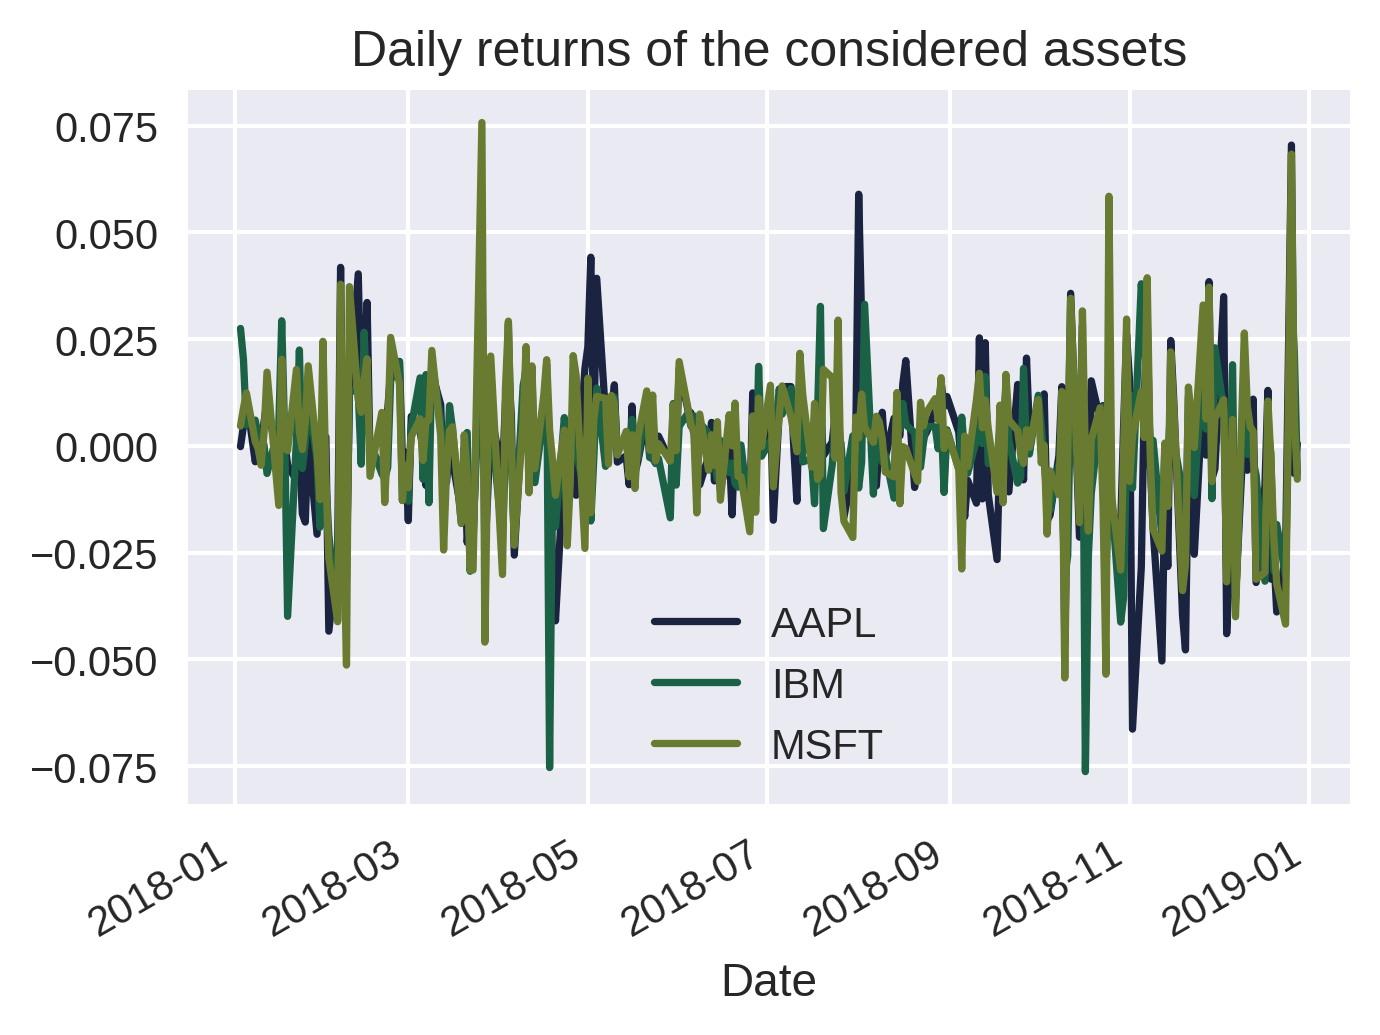

In [154]:
returns_df.plot(title = 'Daily returns of the considered assets')

5. Simulate random portfolio weights:

In [155]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
# Return random floats in the half-open interval [0.0, 1.0) 
# Results are from the "continuous uniform" distribution over the stated interval.

weights /= np.sum(weights, axis=1)[:,np.newaxis]
# /= is equivalent to x = x/3 

6. Calculate portfolio metrics:

In [156]:
  portf_rtns = np.dot(weights,avg_returns)

  portf_vol = []
  for i in range(0, len(weights)): 
      portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                      np.dot(cov_mat, weights[i]))))
  

  portf_vol = np.array(portf_vol) 
  portf_sharpe_ratio = portf_rtns / portf_vol 
  
# Sharpe ratio = (mu - r_f) / (volatility) = ([w1,...,w4]*[r_1, ..., r_4]' - risk free rate) / sqrt( [(w1),(w2),... (w4)]*VAR-COV* [(w1),(w2),...,(w4)]')

7. Create a joint DataFrame with all data:

In [157]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 
                                 'volatility': portf_vol, 
                                 'sharpe_ratio': portf_sharpe_ratio})

portf_results_df 

,returns,volatility,sharpe_ratio
0,-0.041840,0.229741,-0.182118
1,-0.032099,0.250965,-0.127902
2,-0.052786,0.232481,-0.227057
3,0.101938,0.262020,0.389045
4,-0.038378,0.251882,-0.152365
...,...,...,...
99995,0.061836,0.245998,0.251370
99996,0.049962,0.250287,0.199618
99997,-0.048927,0.229516,-0.213177
99998,0.050206,0.256902,0.195430


8. Locate the points creating the Efficient Frontier:

In [158]:
N_POINTS = 100 
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)

portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS): 
    if portf_rtns_ef[point_index] not in portf_rtns: 
         indices_to_skip.append(point_index) 
         continue 
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index]) 
    # return elements chosen from x or y depending on condition
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))

portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

9. Plot the Efficient Frontier:

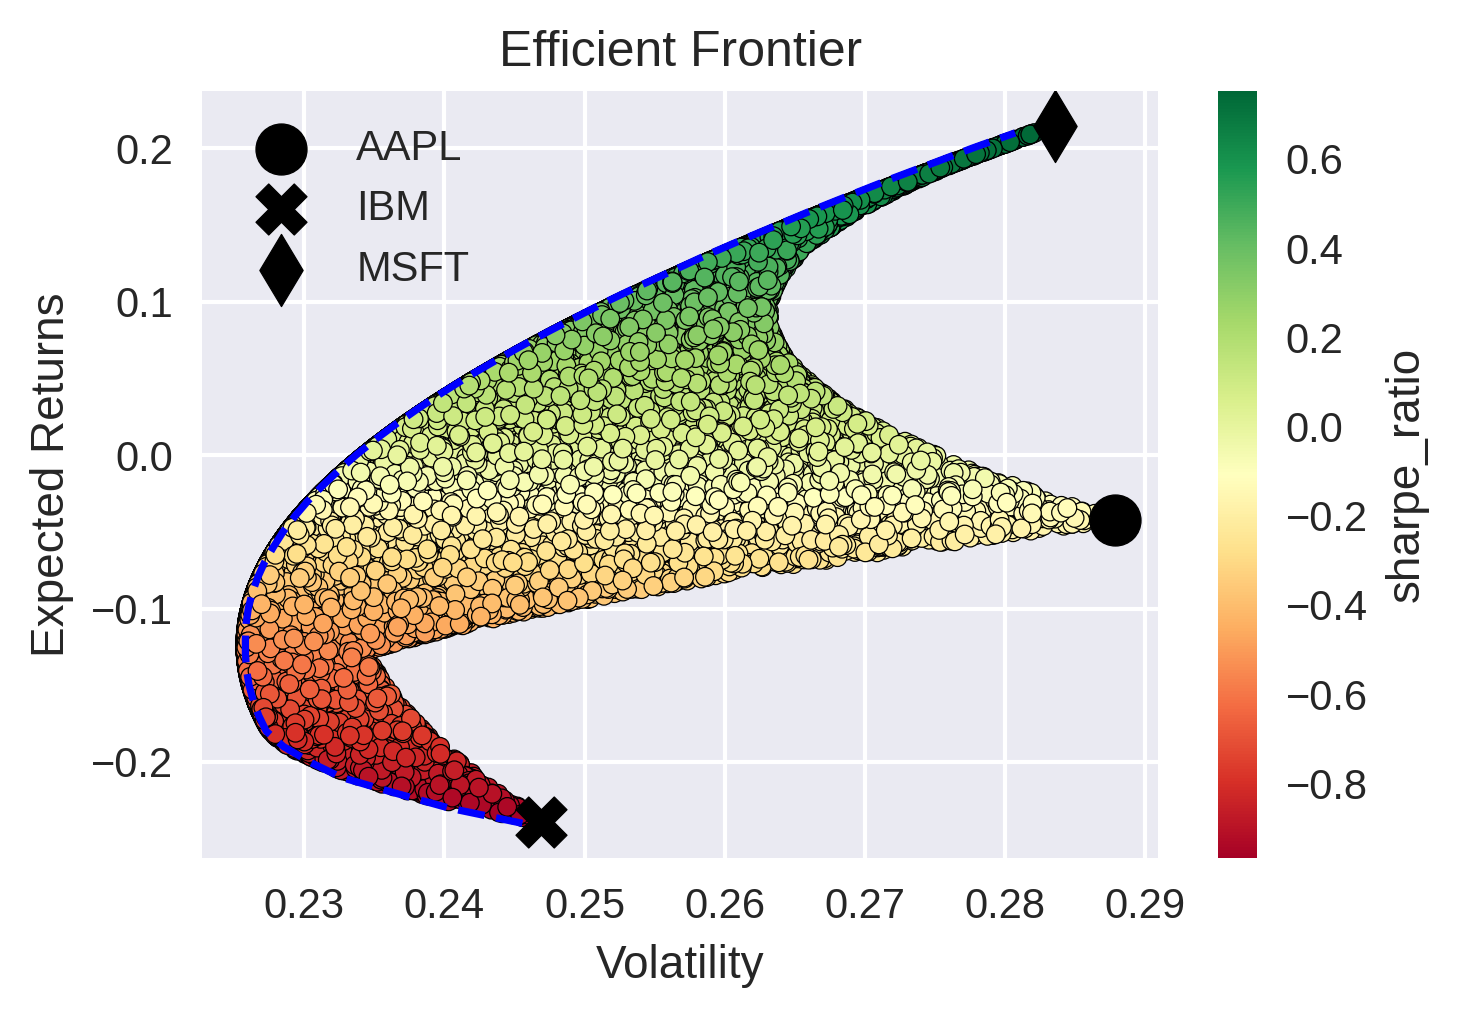

In [159]:
MARKS = ['o', 'X', 'd']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=RISKY_ASSETS[asset_index])
ax.legend()

plt.tight_layout()
plt.show()


### There's more

In [160]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
#np.argmax: returns the indices of the maximum values along an axis 

max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]
# Access a group of rows and columns by label(s) or a boolean array. 

min_vol_ind = np.argmin(portf_results_df.volatility)

min_vol_portf = portf_results_df.loc[min_vol_ind]

In [161]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 21.28% volatility: 28.30% sharpe_ratio: 75.20% 
Weights
AAPL: 0.19% IBM: 0.29% MSFT: 99.52% 

In [162]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: -12.38% volatility: 22.58% sharpe_ratio: -54.84% 
Weights
AAPL: 28.08% IBM: 58.69% MSFT: 13.22% 

In [163]:
#Weights of each asset:
#AAPL: 28.08% IBM: 58.69% MSFT: 13.22% 

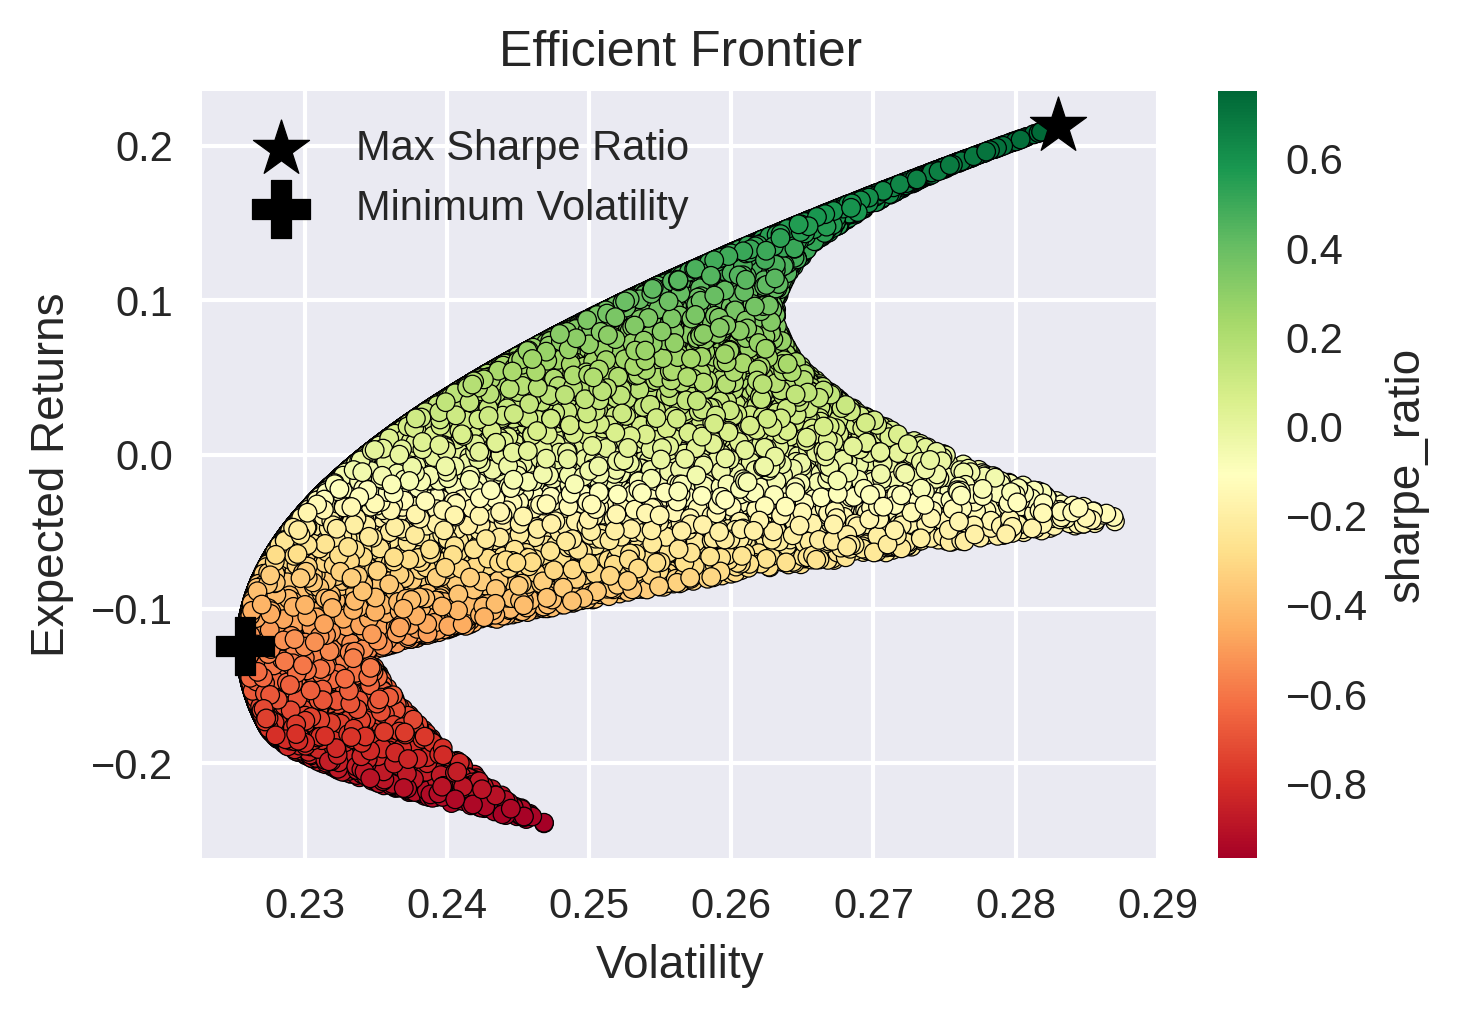

In [164]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, 
           y=max_sharpe_portf.returns, 
           c='black', marker='*', 
           s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, 
           y=min_vol_portf.returns, 
           c='black', marker='P', 
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
plt.show()

In [165]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [166]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams['lines.linewidth'] = 1
warnings.simplefilter(action='ignore', category=FutureWarning)



# **Implementing the CAPM in Python**
** CAPM: Capital Asset Pricing Model 


1.   Market portfolio (S&P 500 index) - Tangent portfolio (CML & Efficient frontier) 
2.   Individual asset's return-risk(volatility) 



How to do it...

1.   Import the libraries:



In [167]:
#import pandas as pd
#!pip install yfinance 
#import yfinance as yf
import statsmodels.api as sm


2.   Specify the risky asset and the time horizon:


In [168]:
RISKY_ASSET = 'AMZN'
MARKET_BENCHMARK = '^GSPC'
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

In [169]:

df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

Downloaded 250 rows of data.



3. Resample to monthly data and calculate simple returns:




In [170]:
X = df['Adj Close'].rename(columns={RISKY_ASSET: 'asset', 
                                    MARKET_BENCHMARK: 'market'}) \
                   .resample('M') \
                   .last() \
                   .pct_change() \
                   .dropna()
X.head()

,asset,market
Date,,
2018-02-28,0.042429,-0.038947
2018-03-31,-0.043049,-0.026884
2018-04-30,0.082075,0.002719
2018-05-31,0.040539,0.021608
2018-06-30,0.043065,0.004842



4. Calculate beta using the covariance approach:



In [171]:
covariance = X.cov().iloc[0,1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance 
beta

1.851794747919731

5. Prepare the input and estimate CAPM as a linear regression:

In [172]:
X

,asset,market
Date,,
2018-02-28,0.042429,-0.038947
2018-03-31,-0.043049,-0.026884
2018-04-30,0.082075,0.002719
2018-05-31,0.040539,0.021608
2018-06-30,0.043065,0.004842
2018-07-31,0.045676,0.036022
2018-08-31,0.132364,0.030263
2018-09-30,-0.004824,0.004294
2018-10-31,-0.202192,-0.069403


In [173]:
sm.add_constant(X)

,const,asset,market
Date,,,
2018-02-28,1.0,0.042429,-0.038947
2018-03-31,1.0,-0.043049,-0.026884
2018-04-30,1.0,0.082075,0.002719
2018-05-31,1.0,0.040539,0.021608
2018-06-30,1.0,0.043065,0.004842
2018-07-31,1.0,0.045676,0.036022
2018-08-31,1.0,0.132364,0.030263
2018-09-30,1.0,-0.004824,0.004294
2018-10-31,1.0,-0.202192,-0.069403


In [174]:
# OLS REGRESSION equation: y = a + bx 
# y: individual stock return (AMZN)
# x: market average stock return (^GSPC)

# 추정하고 싶은 변수 (estimate): a, b 
# a: y의 절편 
# **b**: y와 x의 선형 관계를 나타내는 계수 

# separate target (종속변수: 왼편에 놓이는 변수)
y = X.pop('asset')

# y = a*1 + b*x (scalar)
# Y (Nx 1 행렬) = [1 X] X [a b]' {(N * 2 행렬) X (2x1 행렬)} 

# add constant 
X = sm.add_constant(X)

# define and fit the regression model 
capm_model = sm.OLS(y,X).fit()

# print results 
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     20.10
Date:                Mon, 19 Dec 2022   Prob (F-statistic):            0.00152
Time:                        14:50:10   Log-Likelihood:                 17.095
No. Observations:                  11   AIC:                            -30.19
Df Residuals:                       9   BIC:                            -29.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0259      0.018      1.471      0.1

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### **There's more...**

**Risk-free rate (13 Week Treasury Bill)**

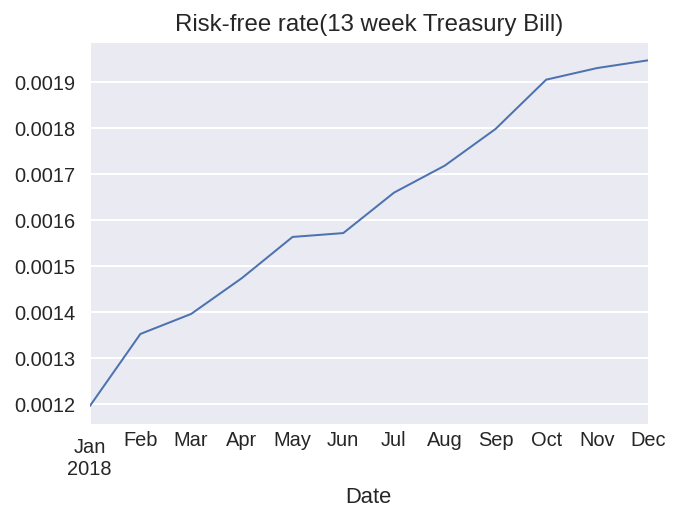

In [175]:
# period lenght in days
N_DAYS = 90

# download data from Yahoo finance
df_rf = yf.download('^IRX',
                    start=START_DATE,
                    end=END_DATE,
                    progress=False)

# resample to monthly by taking last value from each month
rf = df_rf.resample('M').last().Close / 100

# calculate the corresponding daily risk-free return  
rf = ( 1 / (1 - rf * N_DAYS / 360) )**(1 / N_DAYS)  

# convert to monthly and subtract 1
rf = (rf ** 30) - 1

# plot the risk-free rate
rf.plot(title = 'Risk-free rate(13 week Treasury Bill)')
plt.show()

**Risk-free rate (3-Month Treasury Bill)**

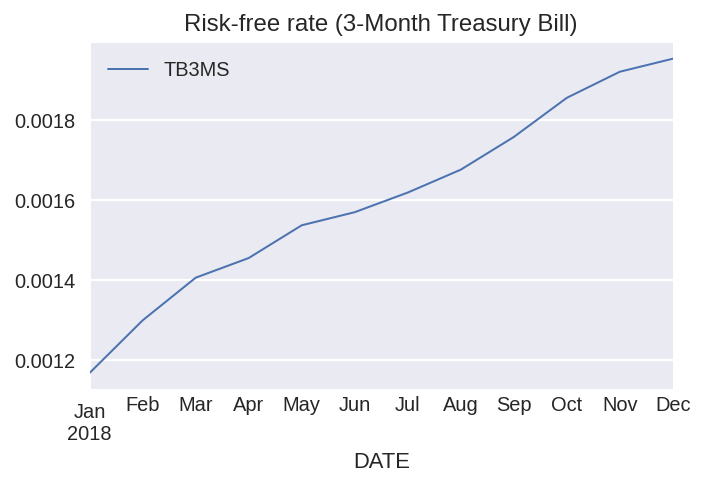

In [176]:
import pandas_datareader.data as web

# download the data 
rf = web.DataReader('TB3MS', 'fred', start=START_DATE, end=END_DATE)

# convert to monthly
rf = (1 + (rf / 100)) ** (1 / 12) - 1

# plot the risk-free rate
rf.plot(title='Risk-free rate (3-Month Treasury Bill)')

plt.tight_layout()
# plt.savefig('images/ch4_im3.png')
plt.show()

# **Monte Carlo simulations in finance**

**Simulating stock price dynamics using Geometric Brownian Motion**

How to do it...

1.   Import libararies: 

In [177]:
import numpy as np
import pandas as pd
import yfinance as yf

In [178]:
RISKY_ASSET = 'MSFT'
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

In [179]:
df = yf.download(RISKY_ASSET, start=START_DATE, 
                 end=END_DATE, adjusted=True)
print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  1 of 1 completed
Downloaded 250 rows of data.



2. Calculate daily returns:


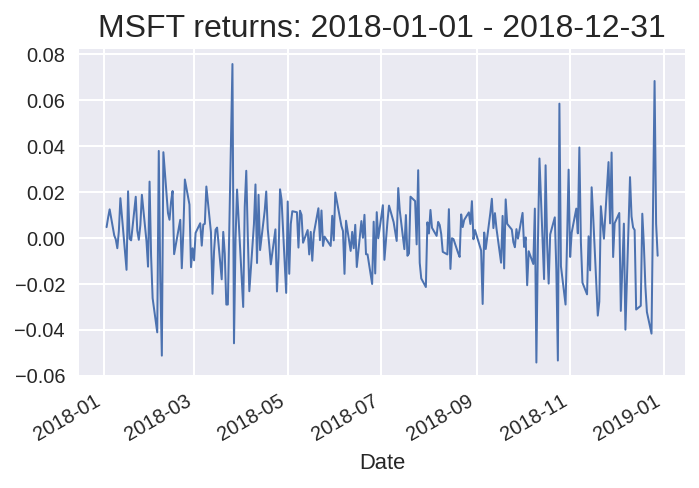

Average return: 0.09%


In [180]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()

ax = returns.plot()
ax.set_title(f'{RISKY_ASSET} returns: {START_DATE} - {END_DATE}', 
             fontsize=16)

plt.tight_layout()
# plt.savefig('images/ch6_im1.png')
plt.show()

print(f'Average return: {100 * returns.mean():.2f}%')

2. Split data into the training and test sets:

In [181]:
train = returns['2018-01-01':'2018-06-30']
test = returns['2018-07-01':'2018-12-31']

3. Specify the parameters of the simulation:

In [182]:
T = len(test)
N = len(test) 
s_0 = adj_close[train.index[-1]]
N_SIM = 100 
mu = train.mean()
sigma = train.std()

4. Define the function used for simulations:

In [183]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    np.random.seed(random_seed)

    dt = T/N 
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis =1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

5. Run the simulations

In [184]:
gbm_simulations = simulate_gbm(s_0, mu, sigma, N_SIM, T, N)

6. Plot simulation results:

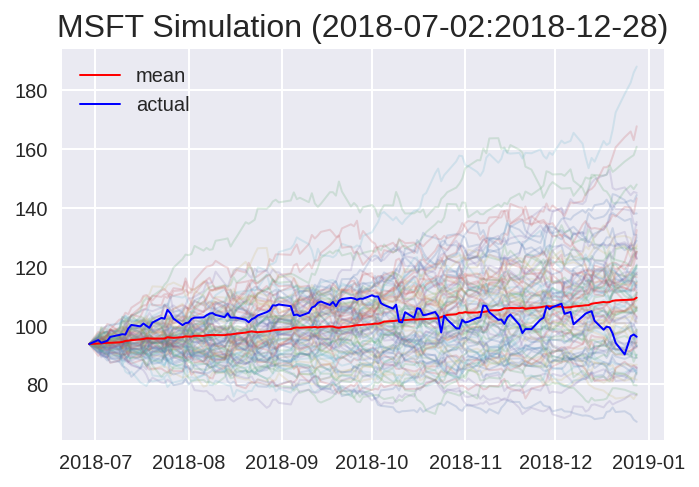

In [185]:

# prepare objects for plotting 
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
#plt.savefig('images/ch6_im2.png')
plt.show()

There's **more**